### Import Libraries and connect to drive

In [ ]:
import numpy as np
import pandas as pd
import os
import cv2
import math
import random
import matplotlib.pyplot as plt
import shutil
from sklearn.preprocessing import QuantileTransformer
from PIL import Image
import warnings
warnings.filterwarnings("ignore")
# importing required libraries
import numpy as np
import pandas as pd

import pickle # saving and loading trained model
from os import path

# importing required libraries for normalizing data
from sklearn import preprocessing
from sklearn.preprocessing import StandardScaler

# importing library for plotting
import matplotlib.pyplot as plt

# importing library for support vector machine classifier
from sklearn.svm import SVC
# importing library for K-neares-neighbor classifier
from sklearn.neighbors import KNeighborsClassifier
# importing library for Linear Discriminant Analysis Model
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
# importing library for Quadratic Discriminant Analysis Model
from sklearn.discriminant_analysis import QuadraticDiscriminantAnalysis

from sklearn import metrics
from sklearn.metrics import accuracy_score # for calculating accuracy of model
from sklearn.model_selection import train_test_split # for splitting the dataset for training and testing
from sklearn.metrics import classification_report # for generating a classification report of model

from sklearn.metrics import precision_score
from sklearn.metrics import recall_score
from sklearn.metrics import f1_score

from sklearn.metrics import roc_auc_score
from sklearn.metrics import roc_curve, auc

from keras.layers import Dense # importing dense layer
from keras.models import Sequential #importing Sequential layer
from keras.models import model_from_json # saving and loading trained model

from keras.layers import LSTM
from keras.layers import Input
from keras.models import Model

# representation of model layers
from keras.utils.vis_utils import plot_model

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


### Data Transformation

In [ ]:
df = pd.read_csv("/content/drive/MyDrive/MajorProjectKDD/datasets/multi_data.csv")

In [ ]:
df.head()

,Unnamed: 0,logged_in,srv_serror_rate,serror_rate,dst_host_serror_rate,dst_host_same_srv_rate,dst_host_srv_serror_rate,dst_host_srv_count,same_srv_rate,protocol_type_icmp,...,flag_S3,flag_SF,flag_SH,intrusion,Dos,Probe,R2L,U2R,normal,Label
0,0,0,0.0,0.0,0.00,0.17,0.00,25,1.00,0,...,0,1,0,4,0,0,0,0,1,normal
1,1,0,0.0,0.0,0.00,0.00,0.00,1,0.08,0,...,0,1,0,4,0,0,0,0,1,normal
2,2,0,1.0,1.0,1.00,0.10,1.00,26,0.05,0,...,0,0,0,0,1,0,0,0,0,Dos
3,3,1,0.2,0.2,0.03,1.00,0.01,255,1.00,0,...,0,1,0,4,0,0,0,0,1,normal
4,4,1,0.0,0.0,0.00,1.00,0.00,255,1.00,0,...,0,1,0,4,0,0,0,0,1,normal


In [ ]:
# Transform all features into the scale of [0,1]

numeric_features = df.dtypes[df.dtypes != 'object'].index
scaler = QuantileTransformer() 
numeric_features
df[numeric_features] = scaler.fit_transform(df[numeric_features])

In [ ]:
# Multiply the feature values by 255 to transform them into the scale of [0,255]
df[numeric_features] = df[numeric_features].apply(
    lambda x: (x*255))

In [ ]:
df.describe()

,Unnamed: 0,logged_in,srv_serror_rate,serror_rate,dst_host_serror_rate,dst_host_same_srv_rate,dst_host_srv_serror_rate,dst_host_srv_count,same_srv_rate,protocol_type_icmp,...,flag_S2,flag_S3,flag_SF,flag_SH,intrusion,Dos,Probe,R2L,U2R,normal
count,125973.000000,125973.000000,125973.000000,125973.000000,125973.000000,125973.000000,125973.000000,125973.000000,125973.000000,125973.000000,...,125973.000000,125973.000000,125973.000000,125973.000000,125973.000000,125973.000000,125973.000000,125973.000000,125973.000000,125973.000000
mean,127.877318,100.912577,73.986696,76.389492,83.381819,146.297644,78.421415,136.861578,175.568975,16.783001,...,0.257079,0.099188,151.706913,0.548570,147.170483,92.967422,23.594580,2.014122,0.105261,136.318616
std,73.433093,124.697564,114.655876,114.609533,114.457462,94.033687,114.745300,87.494939,100.976413,63.229960,...,8.092561,5.028248,125.181467,11.814631,119.462425,122.734961,73.891522,22.573181,5.179826,127.195167
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,64.184951,0.000000,0.000000,0.000000,0.000000,66.366366,0.000000,61.261261,63.813814,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,127.645529,0.000000,0.000000,0.000000,0.000000,126.734234,0.000000,125.968468,255.000000,0.000000,...,0.000000,0.000000,255.000000,0.000000,255.000000,0.000000,0.000000,0.000000,0.000000,255.000000
75%,192.249062,255.000000,255.000000,255.000000,255.000000,255.000000,255.000000,255.000000,255.000000,0.000000,...,0.000000,0.000000,255.000000,0.000000,255.000000,255.000000,0.000000,0.000000,0.000000,255.000000
max,255.000000,255.000000,255.000000,255.000000,255.000000,255.000000,255.000000,255.000000,255.000000,255.000000,...,255.000000,255.000000,255.000000,255.000000,255.000000,255.000000,255.000000,255.000000,255.000000,255.000000


### Generate images for each class

In [ ]:
df.Label.value_counts()

normal    67343
Dos       45927
Probe     11656
R2L         995
U2R          52
Name: Label, dtype: int64

In [ ]:
df0=df[df['Label']=='normal'].drop(['Label'],axis=1)
df1=df[df['Label']=='Dos'].drop(['Label'],axis=1)
df2=df[df['Label']=='Probe'].drop(['Label'],axis=1)
df3=df[df['Label']=='R2L'].drop(['Label'],axis=1)
# df4=df[df['Label']=='U2R'].drop(['Label'],axis=1)

In [ ]:
# Generate 33*33*3 color images for class 0 (Normal)
count=0
ims = []

image_path = "/content/drive/MyDrive/MajorProjectKDD/multi/train/0/"
os.makedirs(image_path)

for i in range(0, len(df0)):  
    count=count+1
    if count<=33:
        im=df0.iloc[i].values 
        ims=np.append(ims,im)
    else:
        ims=np.array(ims).reshape(33,33,3)
        array = np.array(ims, dtype=np.uint8)
        new_image = Image.fromarray(array)
        new_image.save(image_path+str(i)+'.png')
        count=0
        ims = []

In [ ]:
print(len(df0))

67343


In [ ]:
# Generate 33*33*3 color images for class 1 (Dos)
count=0
ims = []

image_path = "/content/drive/MyDrive/MajorProjectKDD/multi/train/1/"
os.makedirs(image_path)

for i in range(0, len(df1)):  
    count=count+1
    if count<=33: 
        im=df1.iloc[i].values
        ims=np.append(ims,im)
    else:
        ims=np.array(ims).reshape(33,33,3)
        array = np.array(ims, dtype=np.uint8)
        new_image = Image.fromarray(array)
        new_image.save(image_path+str(i)+'.png')
        count=0
        ims = []

In [ ]:
# Generate 33*33*3 color images for class 2 (Probe)
count=0
ims = []

image_path = "/content/drive/MyDrive/MajorProjectKDD/multi/train/2/"
os.makedirs(image_path)

for i in range(0, len(df2)):  
    count=count+1
    if count<=33: 
        im=df2.iloc[i].values
        ims=np.append(ims,im)
    else:
        ims=np.array(ims).reshape(33,33,3)
        array = np.array(ims, dtype=np.uint8)
        new_image = Image.fromarray(array)
        new_image.save(image_path+str(i)+'.png')
        count=0
        ims = []

In [ ]:
# Generate 33*33*3 color images for class 3 (R2L)
count=0
ims = []

image_path = "/content/drive/MyDrive/MajorProjectKDD/multi/train/3/"
os.makedirs(image_path)

for i in range(0, len(df3)):  
    count=count+1
    if count<=33: 
        im=df3.iloc[i].values
        ims=np.append(ims,im)
    else:
        ims=np.array(ims).reshape(33,33,3)
        array = np.array(ims, dtype=np.uint8)
        new_image = Image.fromarray(array)
        new_image.save(image_path+str(i)+'.png')
        count=0
        ims = []

In [ ]:
## Generate 33*33*3 color images for class 4 (U2R)
# count=0
# ims = []

# image_path = "/content/drive/MyDrive/MajorProjectKDD/multi/train/4/"
# os.makedirs(image_path)

# for i in range(0, len(df4)):  
#     count=count+1
#     if count<=33: 
#         im=df4.iloc[i].values
#         ims=np.append(ims,im)
#     else:
#         ims=np.array(ims).reshape(33,33,3)
#         array = np.array(ims, dtype=np.uint8)
#         new_image = Image.fromarray(array)
#         new_image.save(image_path+str(i)+'.png')
#         count=0
#         ims = []

### Display samples for each category

In [ ]:
img1 = Image.open('/content/drive/MyDrive/MajorProjectKDD/multi/train/0/33.png')
img2 = Image.open('/content/drive/MyDrive/MajorProjectKDD/multi/train/1/33.png')
img3 = Image.open('/content/drive/MyDrive/MajorProjectKDD/multi/train/2/33.png')
img4 = Image.open('/content/drive/MyDrive/MajorProjectKDD/multi/train/3/33.png')
# img5 = Image.open('/content/drive/MyDrive/MajorProjectKDD/multi/train/4/33.png')

Text(0.5, 1.0, 'R2L')

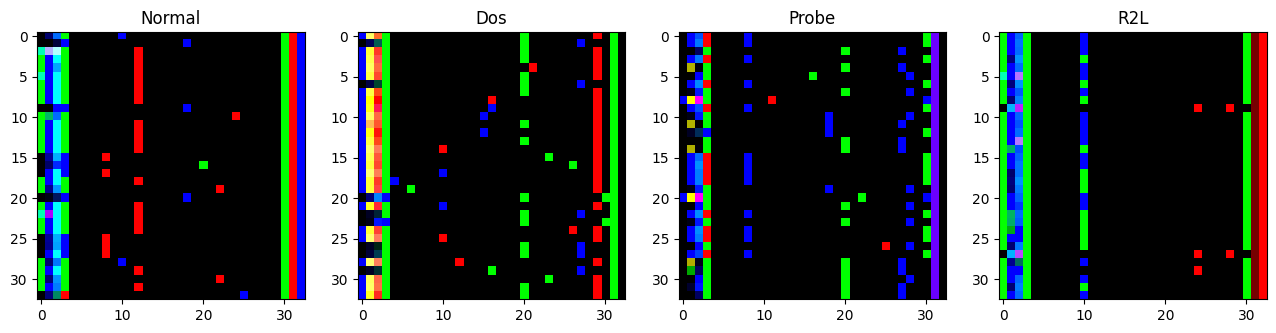

In [ ]:
plt.figure(figsize=(20, 20)) 
plt.subplot(1,5,1)
plt.imshow(img1)
plt.title("Normal")
plt.subplot(1,5,2)
plt.imshow(img2)
plt.title("Dos")
plt.subplot(1,5,3)
plt.imshow(img3)
plt.title("Probe")
plt.subplot(1,5,4)
plt.imshow(img4)
plt.title("R2L")
# plt.subplot(1,5,5)
# plt.imshow(img5)
# plt.title("U2R")

In [ ]:
# Create folders to store images
Train_Dir='/content/drive/MyDrive/MajorProjectKDD/multi/train/'
Val_Dir='/content/drive/MyDrive/MajorProjectKDD/multi/test/'
allimgs=[]
for subdir in os.listdir(Train_Dir):
    for filename in os.listdir(os.path.join(Train_Dir,subdir)):
        filepath=os.path.join(Train_Dir,subdir,filename)
        allimgs.append(filepath)
print(len(allimgs)) # Print the total number of images

3701


In [ ]:
#split a test set from the dataset, train/test size = 80%/20%
Numbers=len(allimgs)//5 	#size of test set (20%)

def mymovefile(srcfile,dstfile):
    if not os.path.isfile(srcfile):
        print ("%s not exist!"%(srcfile))
    else:
        fpath,fname=os.path.split(dstfile)    
        if not os.path.exists(fpath):
            os.makedirs(fpath)               
        shutil.move(srcfile,dstfile)          
        #print ("move %s -> %s"%(srcfile,dstfile))

In [ ]:
# The size of test set
Numbers

740

In [ ]:
# Create the test set
val_imgs=random.sample(allimgs,Numbers)
for img in val_imgs:
    dest_path=img.replace(Train_Dir,Val_Dir)
    mymovefile(img,dest_path)
print('Finish creating test set')

Finish creating test set


In [ ]:
#resize the images 224*224 for better CNN training
def get_224(folder, dstdir):
    imgfilepaths=[]
    for root,dirs,imgs in os.walk(folder):
        for thisimg in imgs:
            thisimg_path=os.path.join(root,thisimg)
            imgfilepaths.append(thisimg_path)
    for thisimg_path in imgfilepaths:
        dir_name,filename=os.path.split(thisimg_path)
        dir_name=dir_name.replace(folder,dstdir)
        new_file_path=os.path.join(dir_name,filename)
        if not os.path.exists(dir_name):
            os.makedirs(dir_name)
        img=cv2.imread(thisimg_path)
        img=cv2.resize(img,(224,224))
        cv2.imwrite(new_file_path,img)
    print('Finish resizing'.format(folder=folder))

In [ ]:
DATA_DIR_224='/content/drive/MyDrive/MajorProjectKDD/multi/train_224/'
get_224(folder='/content/drive/MyDrive/MajorProjectKDD/multi/train/',dstdir=DATA_DIR_224)

Finish resizing


In [ ]:
DATA_DIR2_224='/content/drive/MyDrive/MajorProjectKDD/multi/test_224/'
get_224(folder='/content/drive/MyDrive/MajorProjectKDD/multi/test/',dstdir=DATA_DIR2_224)

Finish resizing
